<a href="https://colab.research.google.com/github/Jayok7/Autoencoder_PyTorch_Feedforward_network_Test.ipynb/blob/main/CNN_Activation_%26_Attention_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Activation & Attention Visualization

### 1. CNN Model with Named Layers


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from collections import OrderedDict

# --- Config ---
BATCH_SIZE = 128
EPOCHS = 10
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Data ---
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST('./data', train=False, download=True, transform=transform)
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader   = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)


class CNNClassifier(nn.Module):
    """
    CNN with explicitly named layers for easy hook attachment.

    Architecture:
        conv1 (1→16)  → ReLU → MaxPool
        conv2 (16→32) → ReLU → MaxPool
        conv3 (32→64) → ReLU
        fc1   (576→128) → ReLU → Dropout
        fc2   (128→10)
    """
    def __init__(self, num_classes=10):
        super().__init__()

        # --- Convolutional Backbone ---
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)   # 28x28 → 28x28
        self.bn1   = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)                           # → 14x14

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 14x14 → 14x14
        self.bn2   = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)                           # → 7x7

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 7x7 → 7x7
        self.bn3   = nn.BatchNorm2d(64)

        # --- Classifier Head ---
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

        # --- Registry of layers we want to inspect ---
        self.target_layers = OrderedDict([
            ('conv1', self.conv1),
            ('conv2', self.conv2),
            ('conv3', self.conv3),
        ])

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 464kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]


### 2. training the model


In [2]:
def train_cnn(model, train_loader, test_loader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * imgs.size(0)
            correct += (out.argmax(1) == labels).sum().item()
            total += labels.size(0)

        # Quick val
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                val_correct += (model(imgs).argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        print(f"Epoch {epoch}/{epochs} | "
              f"Loss: {total_loss/total:.4f} | "
              f"Train Acc: {100*correct/total:.1f}% | "
              f"Val Acc: {100*val_correct/val_total:.1f}%")

    return model

cnn = CNNClassifier().to(DEVICE)
cnn = train_cnn(cnn, train_loader, test_loader, EPOCHS)

Epoch 1/10 | Loss: 0.1286 | Train Acc: 96.0% | Val Acc: 98.2%
Epoch 2/10 | Loss: 0.0478 | Train Acc: 98.5% | Val Acc: 98.5%
Epoch 3/10 | Loss: 0.0364 | Train Acc: 98.8% | Val Acc: 99.0%
Epoch 4/10 | Loss: 0.0298 | Train Acc: 99.1% | Val Acc: 99.1%
Epoch 5/10 | Loss: 0.0240 | Train Acc: 99.2% | Val Acc: 99.1%
Epoch 6/10 | Loss: 0.0233 | Train Acc: 99.3% | Val Acc: 99.2%
Epoch 7/10 | Loss: 0.0184 | Train Acc: 99.4% | Val Acc: 98.9%
Epoch 8/10 | Loss: 0.0157 | Train Acc: 99.5% | Val Acc: 99.0%
Epoch 9/10 | Loss: 0.0146 | Train Acc: 99.5% | Val Acc: 99.2%
Epoch 10/10 | Loss: 0.0141 | Train Acc: 99.5% | Val Acc: 99.3%


### 3. Extraction engine

In [3]:
class ActivationExtractor:
    """
    Attaches forward hooks to specified layers and stores
    their output activations for visualization.

    Usage:
        extractor = ActivationExtractor(model, model.target_layers)
        output = model(input)
        acts = extractor.get_activations()   # dict of {name: tensor}
        extractor.cleanup()
    """
    def __init__(self, model, target_layers: OrderedDict):
        self.activations = {}
        self.hooks = []

        for name, layer in target_layers.items():
            hook = layer.register_forward_hook(self._make_hook(name))
            self.hooks.append(hook)

    def _make_hook(self, name):
        def hook_fn(module, input, output):
            self.activations[name] = output.detach().cpu()
        return hook_fn

    def get_activations(self):
        return self.activations

    def cleanup(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()

### 4. Grad-CAM Implementation

In [4]:
class GradCAM:
    """
    Gradient-weighted Class Activation Mapping.

    Computes the gradient of a target class score w.r.t. a conv layer's
    feature maps, then weights each map by its mean gradient to produce
    a spatial heatmap showing WHERE the network attends.
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Forward hook → store activations
        self.fwd_hook = target_layer.register_forward_hook(self._save_activation)
        # Backward hook → store gradients
        self.bwd_hook = target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, target_class=None):
        """
        Args:
            input_tensor: (1, C, H, W) single image
            target_class: int or None (uses predicted class)
        Returns:
            cam: (H, W) normalized heatmap in [0, 1]
            pred_class: int
        """
        self.model.eval()
        input_tensor = input_tensor.to(DEVICE).requires_grad_(True)

        # Forward
        output = self.model(input_tensor)
        pred_class = output.argmax(dim=1).item()

        if target_class is None:
            target_class = pred_class

        # Backward from target class score
        self.model.zero_grad()
        score = output[0, target_class]
        score.backward()

        # Grad-CAM computation
        # gradients: (1, C, H, W),  activations: (1, C, H, W)
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)  # GAP of gradients → (1, C, 1, 1)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)  # weighted sum → (1, 1, H, W)
        cam = F.relu(cam)  # only positive influence
        cam = cam.squeeze().cpu().numpy()

        # Normalize to [0, 1]
        if cam.max() > 0:
            cam = cam / cam.max()

        return cam, pred_class

    def cleanup(self):
        self.fwd_hook.remove()
        self.bwd_hook.remove()

### 5. Visualization Functions

/tmp/ipython-input-3958404939.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


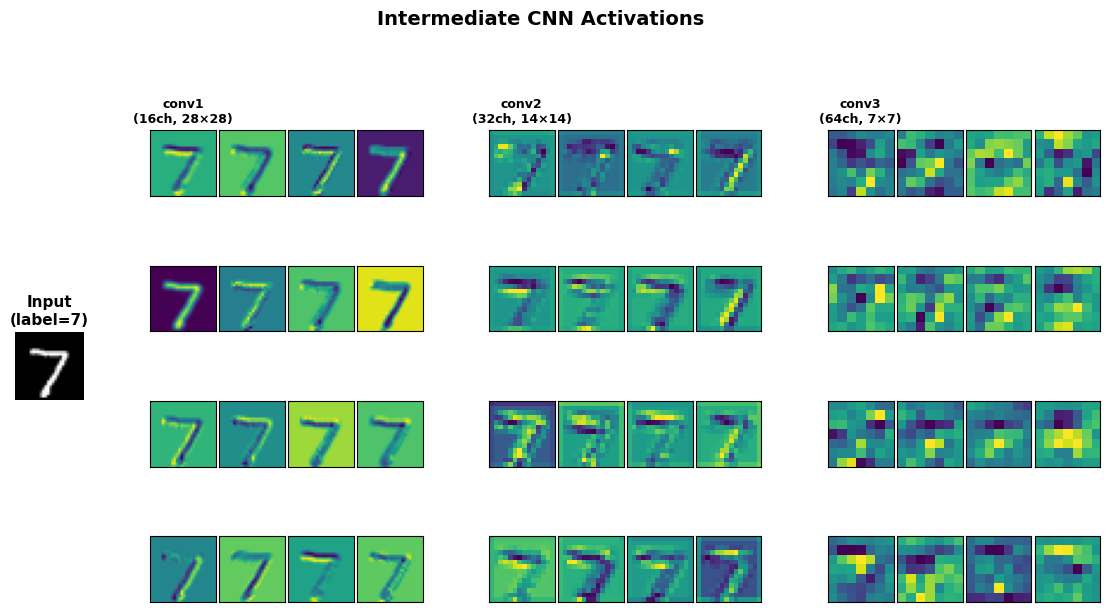

In [5]:
def visualize_activations(model, image, label, max_maps=16):
    """
    Shows feature map activations for each conv layer side by side.

    ┌─────────────────────────────────────────────┐
    │ Input (digit=7)                             │
    ├──────────────┬──────────────┬───────────────┤
    │ conv1 (16ch) │ conv2 (32ch) │ conv3 (64ch)  │
    │ ░░░░  ░░░░   │ ░░░░  ░░░░  │ ░░░░  ░░░░   │
    └──────────────┴──────────────┴───────────────┘
    """
    extractor = ActivationExtractor(model, model.target_layers)
    model.eval()

    with torch.no_grad():
        _ = model(image.unsqueeze(0).to(DEVICE))

    activations = extractor.get_activations()
    extractor.cleanup()

    layer_names = list(activations.keys())
    n_layers = len(layer_names)

    fig = plt.figure(figsize=(4 * n_layers + 2, max_maps // 4 * 1.2 + 2))
    outer_gs = gridspec.GridSpec(1, n_layers + 1,
                                 width_ratios=[1] + [4] * n_layers,
                                 wspace=0.3)

    # --- Input image ---
    ax_input = fig.add_subplot(outer_gs[0])
    ax_input.imshow(image.squeeze(), cmap='gray')
    ax_input.set_title(f'Input\n(label={label})', fontsize=11, fontweight='bold')
    ax_input.axis('off')

    # --- Each conv layer ---
    for idx, name in enumerate(layer_names):
        act = activations[name][0]  # (C, H, W)
        n_channels = min(act.shape[0], max_maps)
        grid_cols = 4
        grid_rows = int(np.ceil(n_channels / grid_cols))

        inner_gs = gridspec.GridSpecFromSubplotSpec(
            grid_rows, grid_cols, subplot_spec=outer_gs[idx + 1],
            wspace=0.05, hspace=0.15
        )

        for i in range(n_channels):
            ax = fig.add_subplot(inner_gs[i])
            ax.imshow(act[i].numpy(), cmap='viridis')
            ax.set_xticks([]); ax.set_yticks([])
            if i == 0:
                ax.set_title(f'{name}\n({act.shape[0]}ch, {act.shape[1]}×{act.shape[2]})',
                             fontsize=9, fontweight='bold')

    plt.suptitle('Intermediate CNN Activations', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


# --- Run for a sample ---
sample_img, sample_label = test_dataset[0]
visualize_activations(cnn, sample_img, sample_label, max_maps=16)

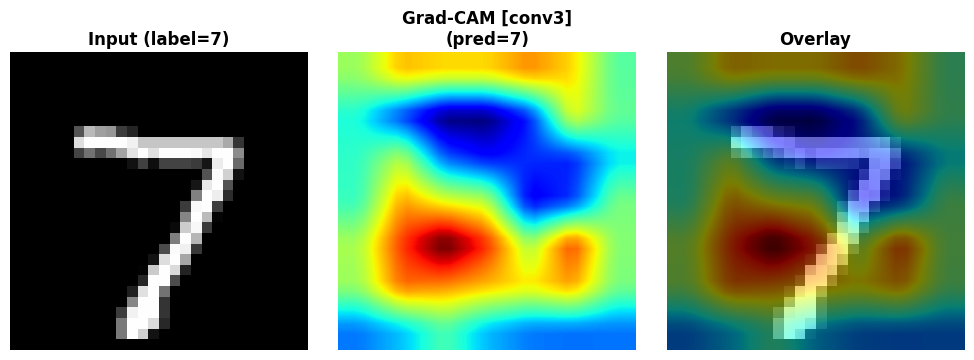

In [6]:
def visualize_gradcam(model, image, label, layer_name='conv3'):
    """
    Overlays Grad-CAM heatmap on the input image for the predicted class.
    """
    target_layer = model.target_layers[layer_name]
    gradcam = GradCAM(model, target_layer)

    cam, pred = gradcam.generate(image.unsqueeze(0))
    gradcam.cleanup()

    # Upsample CAM to input size
    cam_resized = np.array(
        torch.nn.functional.interpolate(
            torch.tensor(cam).unsqueeze(0).unsqueeze(0),
            size=(28, 28), mode='bilinear', align_corners=False
        ).squeeze()
    )

    fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))

    # Original
    axes[0].imshow(image.squeeze(), cmap='gray')
    axes[0].set_title(f'Input (label={label})', fontweight='bold')
    axes[0].axis('off')

    # Heatmap
    axes[1].imshow(cam_resized, cmap='jet', interpolation='bilinear')
    axes[1].set_title(f'Grad-CAM [{layer_name}]\n(pred={pred})', fontweight='bold')
    axes[1].axis('off')

    # Overlay
    axes[2].imshow(image.squeeze(), cmap='gray')
    axes[2].imshow(cam_resized, cmap='jet', alpha=0.5, interpolation='bilinear')
    axes[2].set_title('Overlay', fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

visualize_gradcam(cnn, sample_img, sample_label, layer_name='conv3')

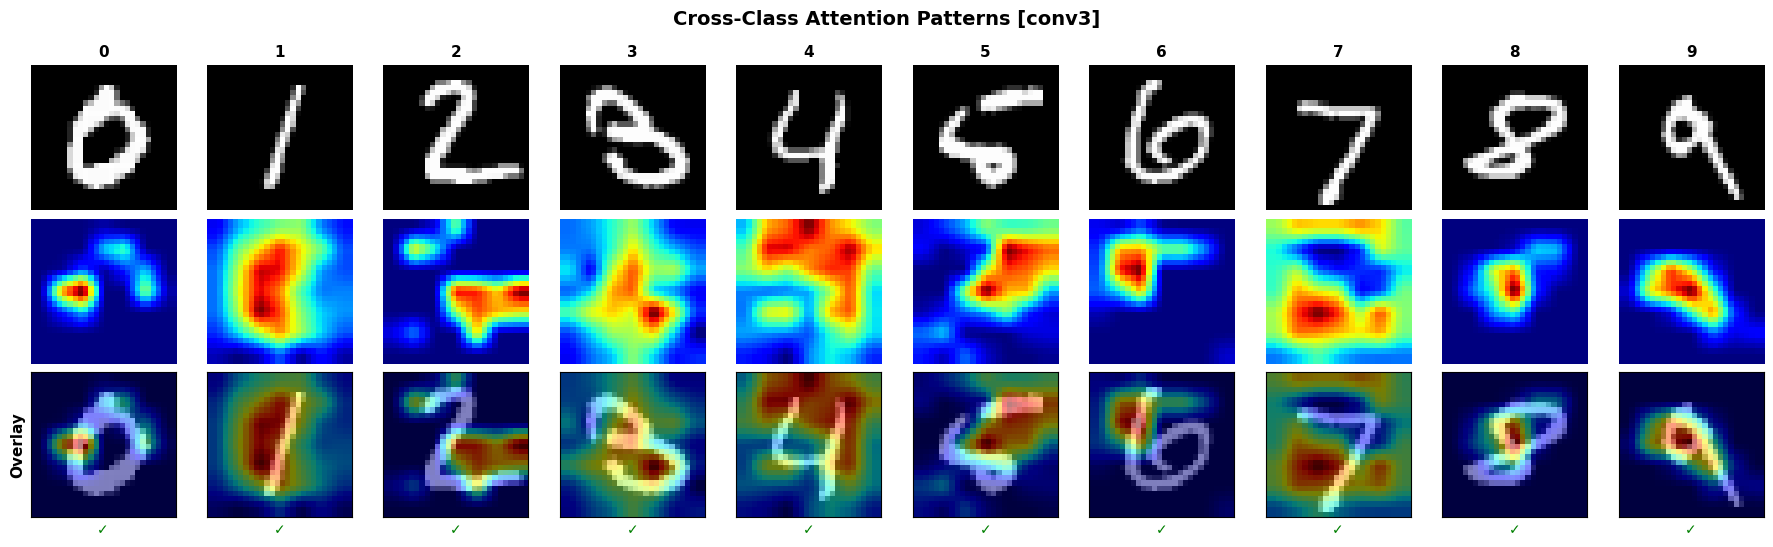

In [7]:
def compare_attention_across_classes(model, test_dataset, layer_name='conv3',
                                      digits=range(10)):
    """
    Shows Grad-CAM attention for one example of EACH digit class,
    revealing how the network encodes different structural patterns.

    ┌────┬────┬────┬────┬────┬────┬────┬────┬────┬────┐
    │  0 │  1 │  2 │  3 │  4 │  5 │  6 │  7 │  8 │  9 │  ← original
    ├────┼────┼────┼────┼────┼────┼────┼────┼────┼────┤
    │  0 │  1 │  2 │  3 │  4 │  5 │  6 │  7 │  8 │  9 │  ← Grad-CAM
    └────┴────┴────┴────┴────┴────┴────┴────┴────┴────┘
    """
    # Collect one sample per digit
    digit_samples = {}
    for img, lbl in test_dataset:
        if lbl not in digit_samples:
            digit_samples[lbl] = img
        if len(digit_samples) == len(digits):
            break

    target_layer = model.target_layers[layer_name]
    n = len(digits)
    fig, axes = plt.subplots(3, n, figsize=(n * 1.8, 5.5))

    for col, digit in enumerate(digits):
        image = digit_samples[digit]
        gradcam = GradCAM(model, target_layer)
        cam, pred = gradcam.generate(image.unsqueeze(0))
        gradcam.cleanup()

        cam_resized = torch.nn.functional.interpolate(
            torch.tensor(cam).unsqueeze(0).unsqueeze(0),
            size=(28, 28), mode='bilinear', align_corners=False
        ).squeeze().numpy()

        # Row 0: Original
        axes[0, col].imshow(image.squeeze(), cmap='gray')
        axes[0, col].set_title(f'{digit}', fontsize=11, fontweight='bold')
        axes[0, col].axis('off')

        # Row 1: Grad-CAM
        axes[1, col].imshow(cam_resized, cmap='jet')
        axes[1, col].axis('off')

        # Row 2: Overlay
        axes[2, col].imshow(image.squeeze(), cmap='gray')
        axes[2, col].imshow(cam_resized, cmap='jet', alpha=0.5)
        mark = '✓' if pred == digit else f'✗({pred})'
        axes[2, col].set_xlabel(mark, fontsize=10,
                                 color='green' if pred == digit else 'red')
        axes[2, col].set_xticks([]); axes[2, col].set_yticks([])

    axes[0, 0].set_ylabel('Input', fontsize=11, fontweight='bold')
    axes[1, 0].set_ylabel('Grad-CAM', fontsize=11, fontweight='bold')
    axes[2, 0].set_ylabel('Overlay', fontsize=11, fontweight='bold')

    plt.suptitle(f'Cross-Class Attention Patterns [{layer_name}]',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

compare_attention_across_classes(cnn, test_dataset, layer_name='conv3')

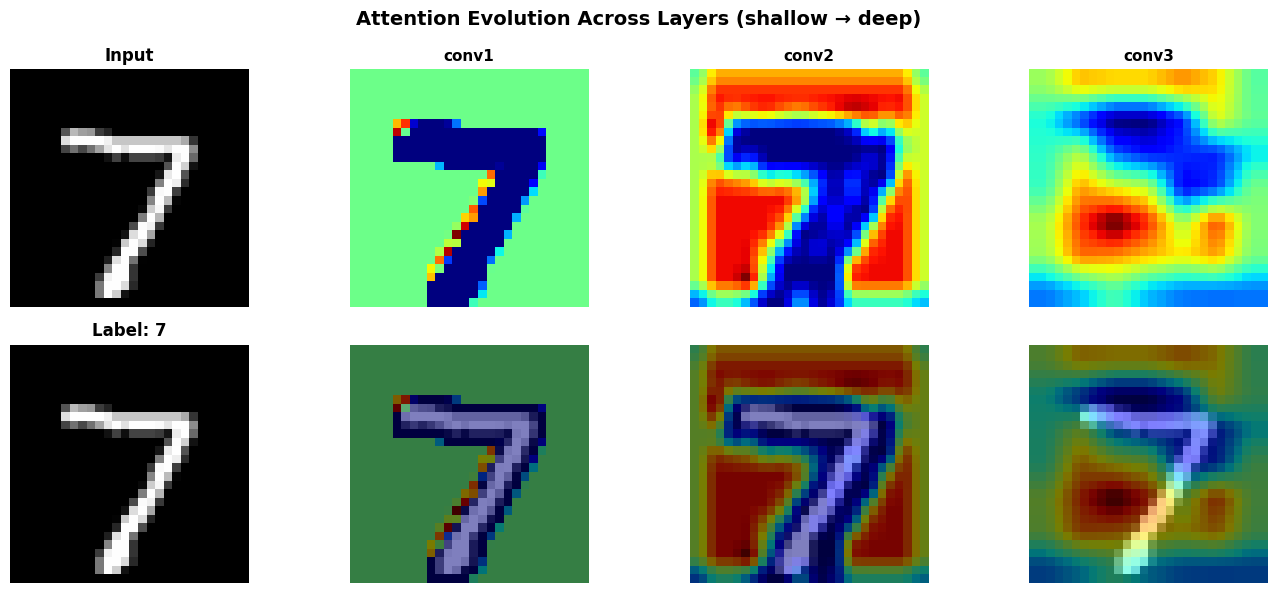

In [8]:
def attention_across_layers(model, image, label):
    """
    Shows how attention refines as information flows deeper.
    conv1 → conv2 → conv3 (coarse → fine-grained)
    """
    layers = list(model.target_layers.keys())
    fig, axes = plt.subplots(2, len(layers) + 1, figsize=(3.5 * (len(layers) + 1), 6))

    # Input column
    for row in range(2):
        axes[row, 0].imshow(image.squeeze(), cmap='gray')
        axes[row, 0].axis('off')
    axes[0, 0].set_title('Input', fontweight='bold')
    axes[1, 0].set_title(f'Label: {label}', fontweight='bold')

    for col, layer_name in enumerate(layers, start=1):
        target_layer = model.target_layers[layer_name]
        gradcam = GradCAM(model, target_layer)
        cam, pred = gradcam.generate(image.unsqueeze(0))
        gradcam.cleanup()

        cam_resized = torch.nn.functional.interpolate(
            torch.tensor(cam).unsqueeze(0).unsqueeze(0),
            size=(28, 28), mode='bilinear', align_corners=False
        ).squeeze().numpy()

        axes[0, col].imshow(cam_resized, cmap='jet')
        axes[0, col].set_title(f'{layer_name}', fontsize=11, fontweight='bold')
        axes[0, col].axis('off')

        axes[1, col].imshow(image.squeeze(), cmap='gray')
        axes[1, col].imshow(cam_resized, cmap='jet', alpha=0.5)
        axes[1, col].axis('off')

    axes[0, 0].set_ylabel('Heatmap', fontweight='bold')
    axes[1, 0].set_ylabel('Overlay', fontweight='bold')

    plt.suptitle('Attention Evolution Across Layers (shallow → deep)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

attention_across_layers(cnn, sample_img, sample_label)

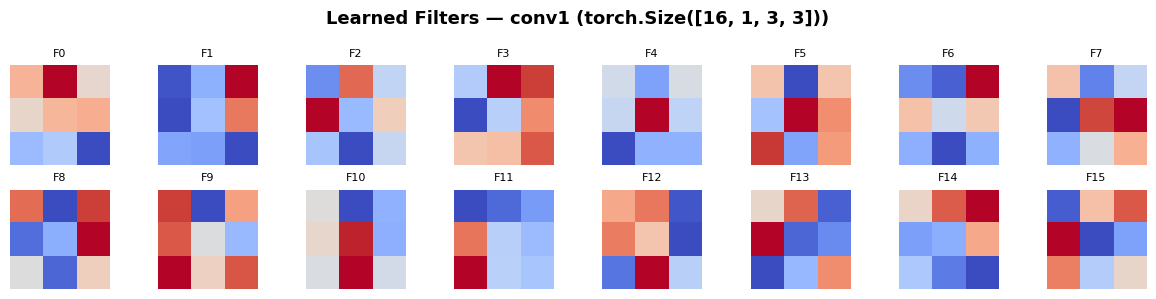

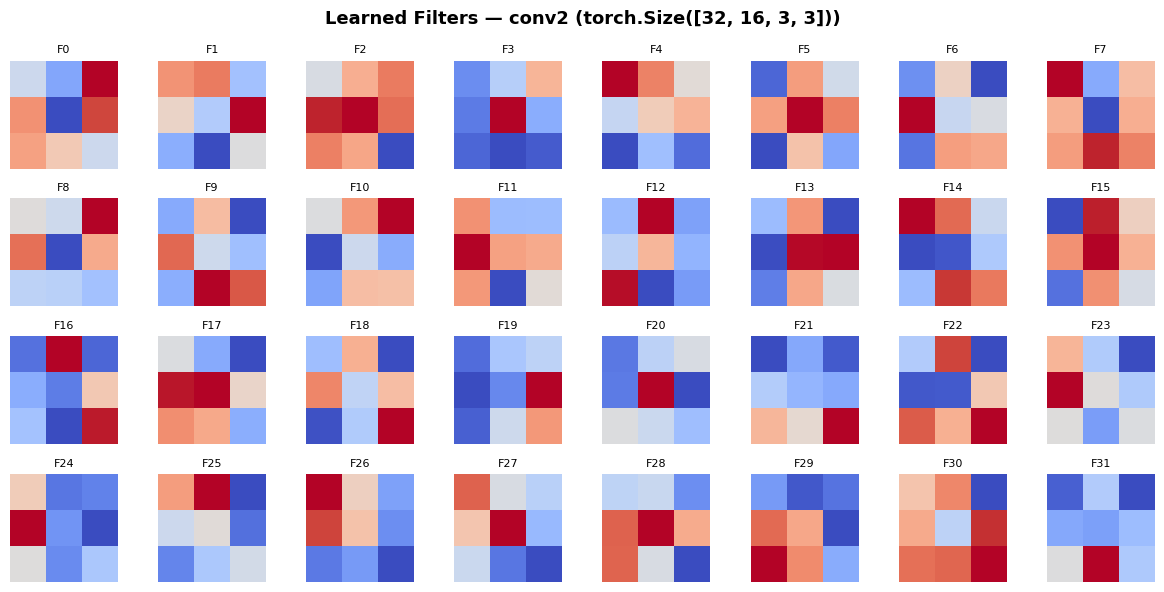

In [9]:
def visualize_filters(model, layer_name='conv1'):
    """
    Visualizes the raw convolutional filters (weights) of a given layer.
    Most interpretable for conv1 since it operates on raw pixels.
    """
    filters = model.target_layers[layer_name].weight.data.cpu()
    n = filters.shape[0]
    cols = 8
    rows = int(np.ceil(n / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))
    axes = axes.flatten()

    for i in range(len(axes)):
        if i < n:
            # For conv1: (out, 1, kH, kW) — show the single channel
            # For deeper: average across input channels
            filt = filters[i].mean(dim=0).numpy()
            axes[i].imshow(filt, cmap='coolwarm', interpolation='nearest')
            axes[i].set_title(f'F{i}', fontsize=8)
        axes[i].axis('off')

    plt.suptitle(f'Learned Filters — {layer_name} ({filters.shape})',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_filters(cnn, 'conv1')
visualize_filters(cnn, 'conv2')

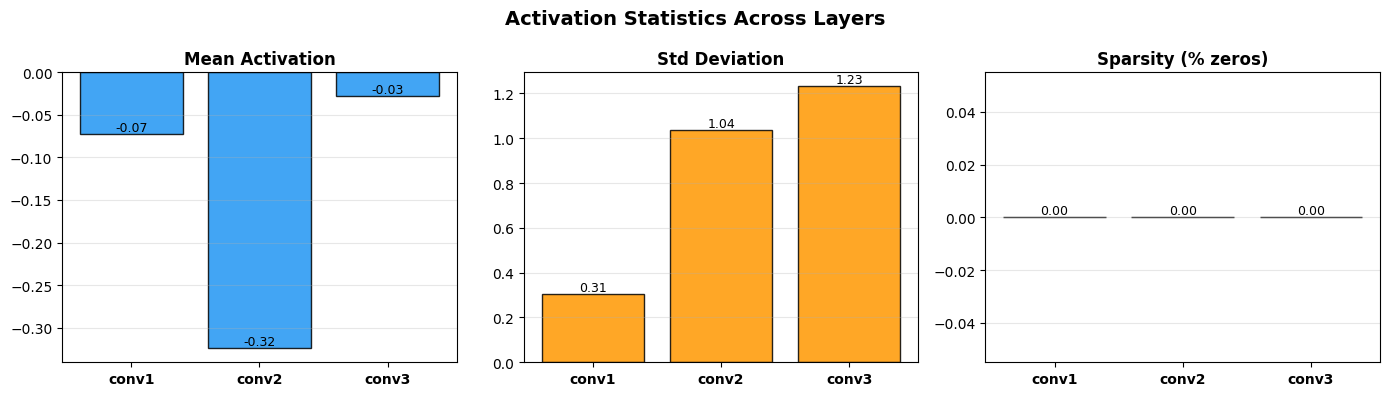

In [10]:
def activation_statistics(model, test_loader, num_batches=10):
    """
    Computes and visualizes activation statistics per layer:
    - Mean activation (is the layer 'alive'?)
    - Sparsity (% of zero activations — dead ReLUs)
    - Std deviation (spread of activations)
    """
    extractor = ActivationExtractor(model, model.target_layers)
    model.eval()

    stats = {name: {'means': [], 'sparsity': [], 'stds': []}
             for name in model.target_layers}

    with torch.no_grad():
        for i, (imgs, _) in enumerate(test_loader):
            if i >= num_batches:
                break
            _ = model(imgs.to(DEVICE))
            acts = extractor.get_activations()

            for name, act in acts.items():
                act_np = act.numpy()
                stats[name]['means'].append(act_np.mean())
                stats[name]['sparsity'].append((act_np == 0).mean() * 100)
                stats[name]['stds'].append(act_np.std())

    extractor.cleanup()

    # --- Plot ---
    layer_names = list(stats.keys())
    x = np.arange(len(layer_names))

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    metrics = [
        ('means',    'Mean Activation',     '#2196F3'),
        ('stds',     'Std Deviation',        '#FF9800'),
        ('sparsity', 'Sparsity (% zeros)',   '#F44336'),
    ]

    for ax, (key, title, color) in zip(axes, metrics):
        values = [np.mean(stats[n][key]) for n in layer_names]
        bars = ax.bar(x, values, color=color, alpha=0.85, edgecolor='black')
        ax.set_xticks(x)
        ax.set_xticklabels(layer_names, fontweight='bold')
        ax.set_title(title, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        # Value labels on bars
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                    f'{val:.2f}', ha='center', va='bottom', fontsize=9)

    plt.suptitle('Activation Statistics Across Layers', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

activation_statistics(cnn, test_loader)

### Full Analysis Pipeline

  CNN INTERPRETABILITY ANALYSIS

[1/6] Learned Filters (conv1)


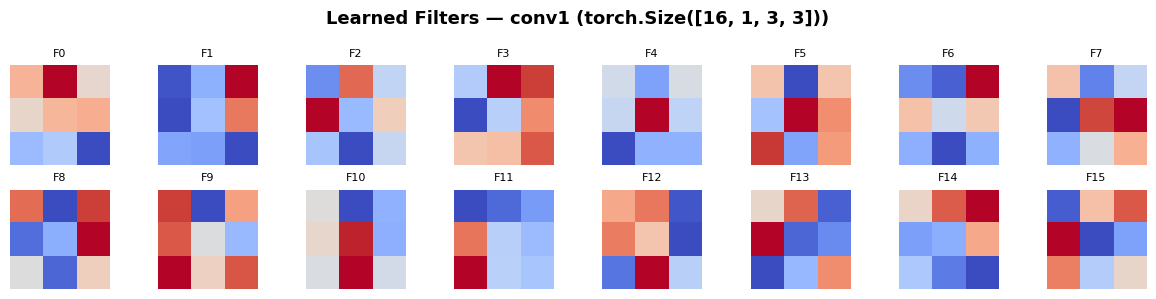


[2/6] Intermediate Activations


/tmp/ipython-input-3958404939.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


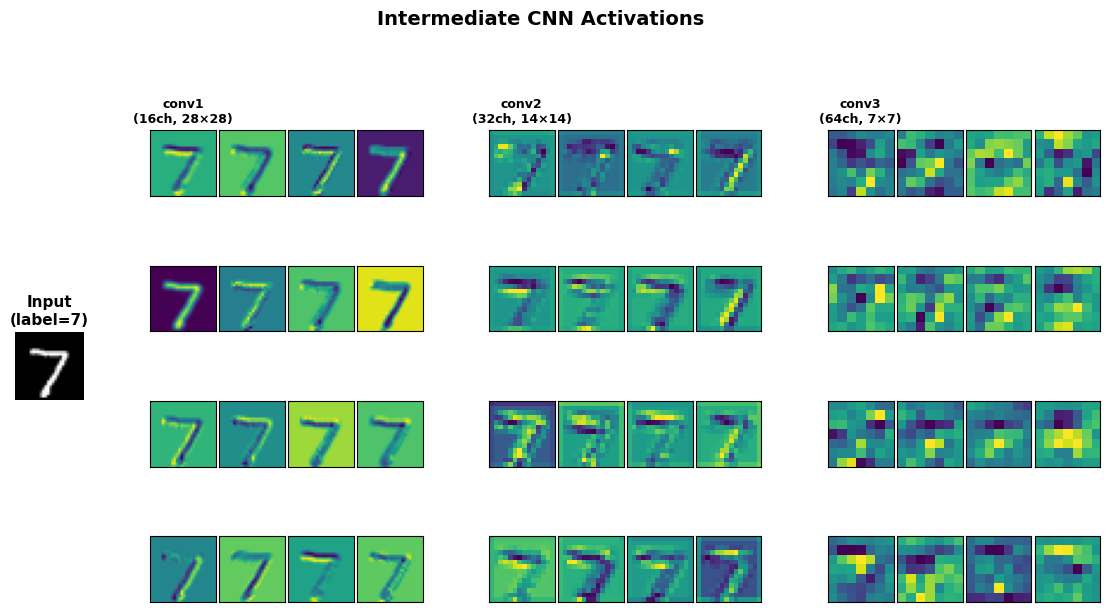


[3/6] Grad-CAM Attention (single sample)


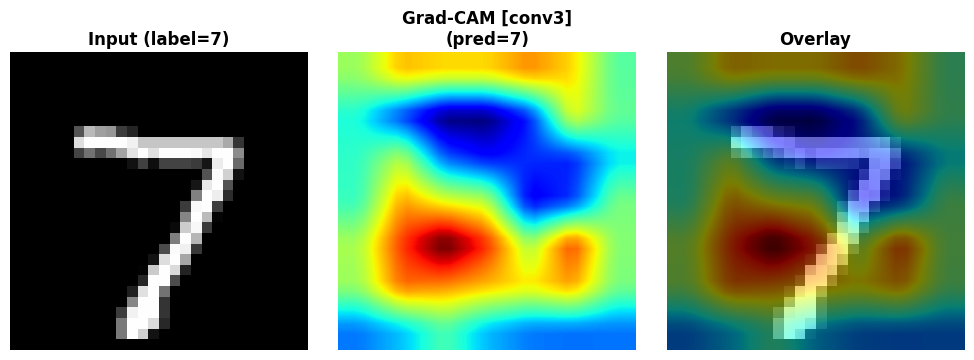


[4/6] Attention Evolution Across Layers


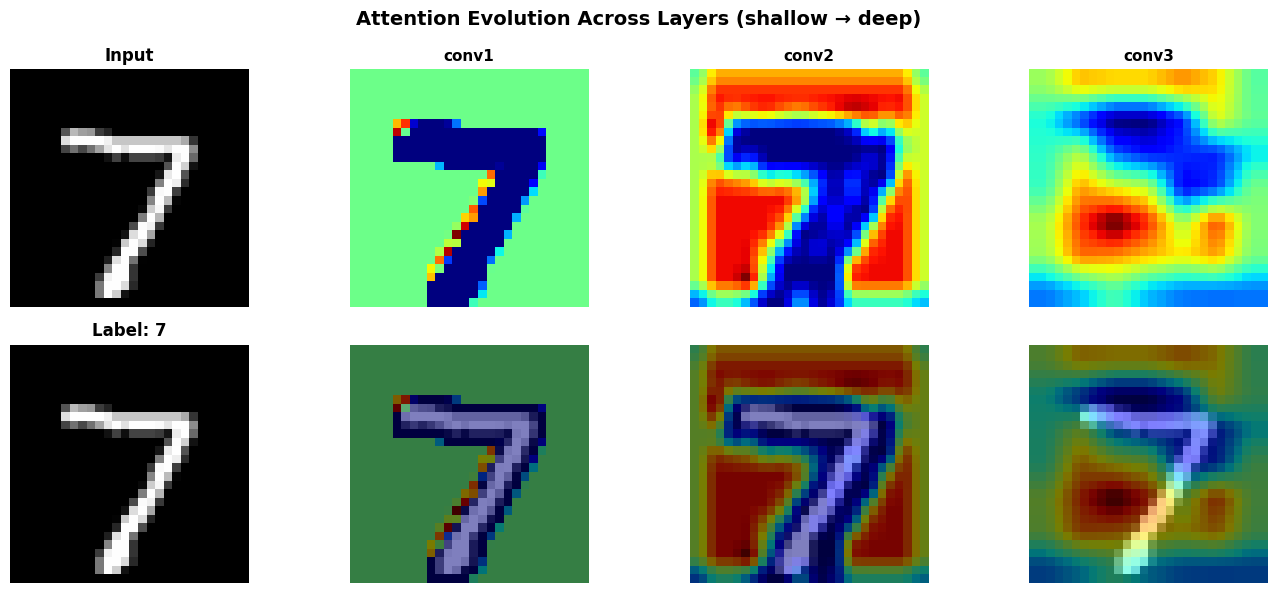


[5/6] Cross-Class Attention Comparison


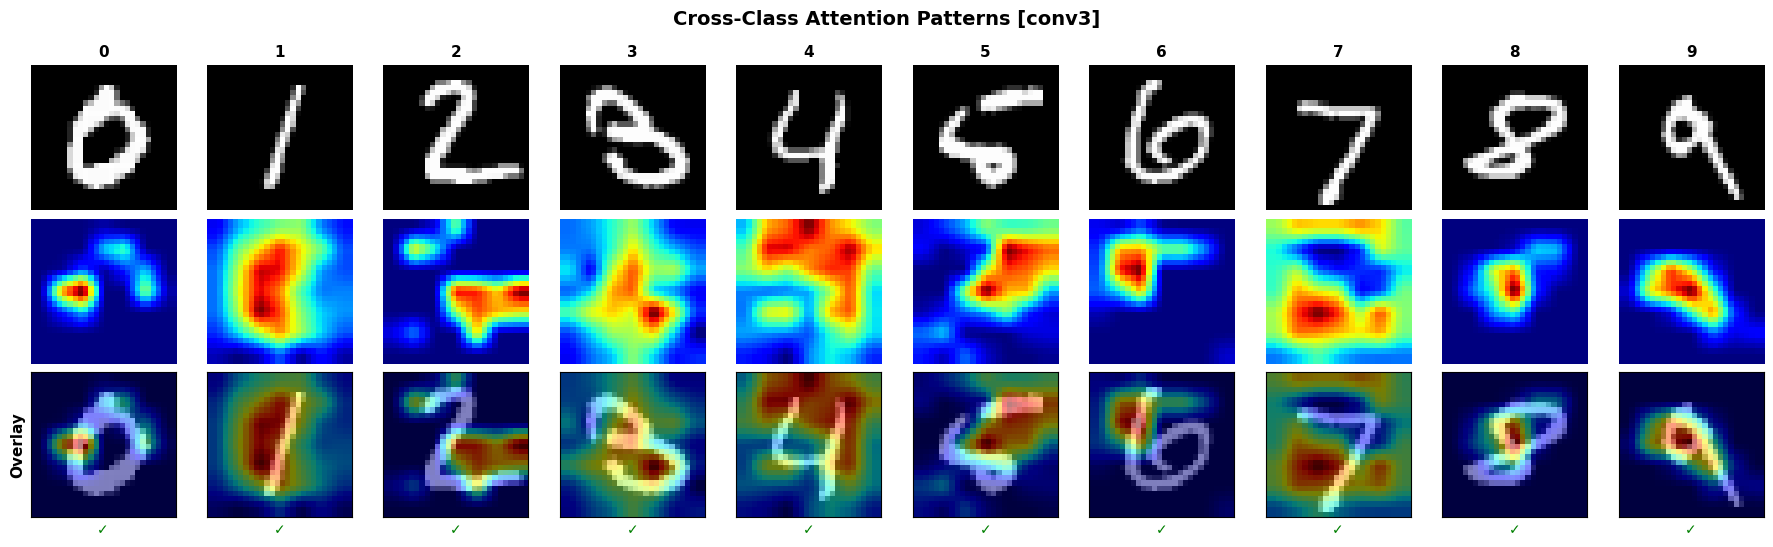


[6/6] Activation Statistics Dashboard


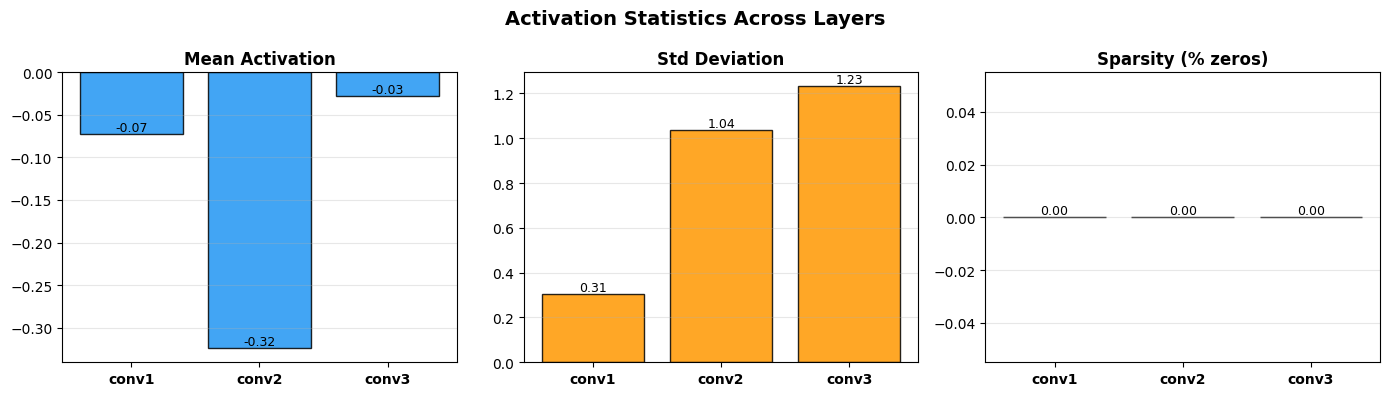


✅ Analysis complete!


In [11]:
def full_analysis(model, test_dataset, test_loader):
    """Run the complete visualization suite."""
    sample_img, sample_label = test_dataset[0]

    print("=" * 60)
    print("  CNN INTERPRETABILITY ANALYSIS")
    print("=" * 60)

    print("\n[1/6] Learned Filters (conv1)")
    visualize_filters(model, 'conv1')

    print("\n[2/6] Intermediate Activations")
    visualize_activations(model, sample_img, sample_label)

    print("\n[3/6] Grad-CAM Attention (single sample)")
    visualize_gradcam(model, sample_img, sample_label)

    print("\n[4/6] Attention Evolution Across Layers")
    attention_across_layers(model, sample_img, sample_label)

    print("\n[5/6] Cross-Class Attention Comparison")
    compare_attention_across_classes(model, test_dataset)

    print("\n[6/6] Activation Statistics Dashboard")
    activation_statistics(model, test_loader)

    print("\n✅ Analysis complete!")

# --- Run everything ---
full_analysis(cnn, test_dataset, test_loader)